In [1]:
pip install pdfplumber==0.5.28 pdfminer.six==20200517

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PyMuPDF

Note: you may need to restart the kernel to use updated packages.


In [74]:
import os
import re
import fitz
import numpy as np
import pdfplumber
import pandas as pd
import requests
import seaborn as sns
from bs4  import BeautifulSoup
from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import f_oneway, kruskal

In [2]:
# Extract data from MyDramaList for previous webtoon adaptations

pdf_folder = "pdf"
shows = []

# Step 1: Extract data from PDF files
for filename in os.listdir(pdf_folder):
    if filename.lower().endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, filename)

        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if not text:
                    continue

                # Extract title, year, episodes, skipping ranking
                lines = text.splitlines()
                i = 0
                while i < len(lines) - 1:
                    title_line = lines[i].strip()
                    info_line = lines[i + 1].strip()

                    # Match title line like "101. Chicken Nugget"
                    title_match = re.match(r"^\d+\.\s+(.*)", title_line)
                    if title_match:
                        title = title_match.group(1)
                        title = title.encode("ascii", "ignore").decode().strip()

                        # Match info line like "Korean Drama - 2024, 10 episodes"
                        info_match = re.search(r"(\d{4}),\s+(\d+)\s+episodes", info_line)
                        if info_match:
                            year = int(info_match.group(1))
                            episodes = int(info_match.group(2))
                            i += 2
                        else:
                            year = None
                            episodes = None
                            i += 1 # Move to next line

                        shows.append({
                            "title": title,
                            "year": year,
                            "episodes": episodes
                        })
                            
                    else:
                        i += 1


# Step 2: Create DataFrame
df_MyDramaList = pd.DataFrame(shows)

if not df_MyDramaList.empty:
    print(f"Total rows: {len(df_MyDramaList)}")
    display(pd.concat([df_MyDramaList.head(10), df_MyDramaList.tail(10)]))
else:
    print("No data extracted")

Total rows: 402


,title,year,episodes
0,Revelations,NaN,NaN
1,Child Shopping,2025.0,8.0
2,The Garden of Harmony,2025.0,16.0
3,The Great Ok Sook,NaN,NaN
4,Manager Kim,NaN,NaN
5,Forest of Humans,NaN,NaN
6,The Fugitives,NaN,NaN
7,Dear Actresses,NaN,NaN
8,Straightforward to the God Farming,NaN,NaN
9,The Villainess's Debut Novel,NaN,NaN


In [3]:
df_Webtoon = pd.read_csv('webtoon-site/webtoon-site-data.csv')
print(df_Webtoon.head())

                                Title                     Author(s)
0                          Sweet Home  Carnby Kim / Youngchan Hwang
1                           Hellbound                  Choi Gyuseok
2  The Sound of Magic: Annarasumanara                     Ilkwon Ha
3                  All of Us Are Dead                 Joo Dong-geun
4             Money Game (The 8 Show)                   BAE jin soo


In [4]:
# Extract Allkpop webtoond drama adaptation list 2024
url = "https://www.allkpop.com/article/2024/12/2024-webtoon-based-k-dramas-that-you-need-to-check-out"
headers = {
    "User-Agent": "Mozilla/5.0"
}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

# Step 2: Initialize a list to store titles
titles = []

# Step 3: Extract titles from <h3> tags
for h3 in soup.find_all('h3'):
    title = h3.get_text(strip=True)
    if title:
        titles.append(title)

# Step 4: Extract titles from <strong> tags within <p> tags
for p in soup.find_all('p'):
    strong = p.find('strong')
    if strong:
        title = strong.get_text(strip=True)
        if title:
            titles.append(title)

# Step 5: Extract titles from <p> tags preceding <iframe> tags
for iframe in soup.find_all('iframe'):
    prev = iframe.find_previous_sibling('p')
    if prev:
        title = prev.get_text(strip=True)
        if title:
            titles.append(title)

# Step 6: Remove duplicates while preserving order
seen = set()
unique_titles = []
for title in titles:
    if title not in seen:
        seen.add(title)
        unique_titles.append(title)

# Step 7: Create a DataFrame with the year appended
df_allkpop= pd.DataFrame({
    'Title': unique_titles,
    'Year': 2024
})

# Preview the result
print(df_allkpop.head(10))

                          Title  Year
0          When the Phone Rings  2024
1                 Lovely Runner  2024
2              Marry My Husband  2024
3        Love Song for Illusion  2024
4  Jeongnyeon: The Star is Born  2024
5             Cinderella At 2AM  2024
6            Wedding Impossible  2024
7                  Pyramid Game  2024
8              A Killer Paradox  2024
9                    Light Shop  2024


In [6]:
# Step 1: Fetch the webpage content
url = "https://www.imkpoper.com/read-blog/896_32-k-dramas-of-2024-based-on-webtoon-confirmed.html"
headers = {
    "User-Agent": "Mozilla/5.0"
}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

# Step 2: Extract all text lines from the article
lines = soup.get_text(separator="\n").split("\n")

# Step 3: Define a regular expression pattern to match the desired lines
pattern = re.compile(r'^\d+\.\s+"(.+?)"\s+/ Schedule status:\s*(.+)$')

# Step 4: Initialize a list to store the extracted data
data = []

# Step 5: Iterate through each line and apply the pattern
for line in lines:
    match = pattern.match(line.strip())
    if match:
        title = match.group(1)
        schedule_info = match.group(2)
        # Extract the year from the schedule_info
        year_match = re.search(r'(\d{4})', schedule_info)
        year = year_match.group(1) if year_match else None
        data.append({'Title': title, 'Year': year})

# Step 6: Create a DataFrame from the extracted data
df_Imkpoper = pd.DataFrame(data)

# Step 7: Display the DataFrame
print(df_Imkpoper)

                    Title  Year
0       Cinderella at 2AM  None
1       History of Losers  None
2       The Borrowed Body  None
3          Chicken Nugget  None
4                 Aquaman  None
5   The Year We Turned 29  None
6               The Witch  None
7              Jung Nyeon  None
8      Delightful Outcast  None
9          Haesi's Shinru  None
10      Weak Hero Class 2  None


In [7]:
# Extract list from Wikipedia for previous webtoon adaptations
base_url = "https://en.wikipedia.org"
category_url = base_url + "/wiki/Category:Television_shows_based_on_South_Korean_webtoons"

def get_titles_from_category(url):
    titles = []
    while url:
        print(f"Fetching: {url}")
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all the tiles in the category page
        for li in soup.select("div.mw-category-group ul li a"):
            titles.append(li.get_text())
        
        # Look for 'next page' link
        next_link = soup.find("a", text="next page")
        if next_link:
            url = base_url + next_link["href"]
        else:
            url = None
    return titles

titles = get_titles_from_category(category_url)
df_WikiKdrama = pd.DataFrame(titles, columns=["Title"])

if not df_WikiKdrama.empty:
    print(f"Total rows: {len(df_WikiKdrama)}")
    display(pd.concat([df_WikiKdrama.head(10), df_WikiKdrama.tail(10)]))
else:
    print("No data extracted")

Fetching: https://en.wikipedia.org/wiki/Category:Television_shows_based_on_South_Korean_webtoons
Total rows: 126


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/525262563.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  next_link = soup.find("a", text="next page")


,Title
0,1 Second (manhwa)
1,The 8 Show
2,All of Us Are Dead
3,Amanza
4,Avengers Social Club
5,Backstreet Rookie
6,Beauty Newbie
7,Between Him and Her
8,Black Knight (South Korean TV series)
9,Bloodhounds (South Korean TV series)


In [8]:
# Assign source labels
df_MyDramaList["Source"] = "MyDramaList"
df_WikiKdrama["Source"] = "WikiKdrama"
df_Webtoon["Source"] = "Webtoon"
df_allkpop["Source"] = "allkpop"
df_Imkpoper["Source"] = "Imkpoper"

# Rename columns to start with capital letters (e.g., "Title")
for df in [df_MyDramaList, df_WikiKdrama, df_Webtoon, df_allkpop, df_Imkpoper]:
    df.rename(columns=lambda x: x.capitalize(), inplace=True)

# Ensure all DataFrames have 'Year' and 'Episodes' columns
for df in [df_Webtoon, df_allkpop, df_Imkpoper]:
    if 'Year' not in df.columns:
        df['Year'] = pd.NA
    if 'Episodes' not in df.columns:
        df['Episodes'] = pd.NA

# Combine all DataFrames
df_comb_adaptations = pd.concat(
    [df_MyDramaList, df_WikiKdrama, df_Webtoon, df_allkpop, df_Imkpoper],
    ignore_index=True
)

# Drop duplicates by Title
df_comb_adaptations = df_comb_adaptations.drop_duplicates(subset="Title", keep="first")

# Drop Source column if not needed
df_comb_adaptations = df_comb_adaptations.drop(columns="Source")

# Reset index
df_comb_adaptations = df_comb_adaptations.reset_index(drop=True)

# Cast Year column with NA support
df_comb_adaptations['Year'] = df_comb_adaptations['Year'].astype('Int64')

# Optional: consistent float formatting
pd.set_option('display.float_format', '{:,.0f}'.format)


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/3890154544.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comb_adaptations = pd.concat(


In [9]:
# Assign source labels
df_MyDramaList["Source"] = "MyDramaList"
df_WikiKdrama["Source"] = "WikiKdrama"
df_Webtoon["Source"] = "Webtoon"
df_allkpop["Source"] = "allkpop"
df_Imkpoper["Source"] = "Imkpoper"

# Capitalize column names
for df in [df_MyDramaList, df_WikiKdrama, df_Webtoon, df_allkpop, df_Imkpoper]:
    df.rename(columns=lambda x: x.capitalize(), inplace=True)

# Ensure 'Year' and 'Episodes' columns exist
for df in [df_Webtoon, df_allkpop, df_Imkpoper]:
    if 'Year' not in df.columns:
        df['Year'] = pd.NA
    if 'Episodes' not in df.columns:
        df['Episodes'] = pd.NA

# Combine all DataFrames
df_comb_adaptations = pd.concat(
    [df_MyDramaList, df_WikiKdrama, df_Webtoon, df_allkpop, df_Imkpoper],
    ignore_index=True
)

# Normalize Title for deduplication
df_comb_adaptations["Title_cleaned"] = df_comb_adaptations["Title"].str.strip().str.lower()

# Drop duplicates based on normalized Title
df_comb_adaptations = df_comb_adaptations.drop_duplicates(subset="Title_cleaned", keep="first")

# Drop helper and source columns
df_comb_adaptations = df_comb_adaptations.drop(columns=["Title_cleaned", "Source"])

# Reset index
df_comb_adaptations = df_comb_adaptations.reset_index(drop=True)

# Cast Year to nullable integer
df_comb_adaptations['Year'] = df_comb_adaptations['Year'].astype('Int64')

# Optional: consistent float formatting
pd.set_option('display.float_format', '{:,.0f}'.format)


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/4211156780.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comb_adaptations = pd.concat(


In [10]:
df_comb_adaptations

,Title,Year,Episodes,Author(s)
0,Revelations,<NA>,NaN,NaN
1,Child Shopping,2025,8,NaN
2,The Garden of Harmony,2025,16,NaN
3,The Great Ok Sook,<NA>,NaN,NaN
4,Manager Kim,<NA>,NaN,NaN
...,...,...,...,...
419,The Year We Turned 29,<NA>,NaN,NaN
420,The Witch,<NA>,NaN,NaN
421,Jung Nyeon,<NA>,NaN,NaN
422,Delightful Outcast,<NA>,NaN,NaN


In [11]:
df_comb_adaptations.to_csv("data/combined/not-clean/combined_adaptations.csv", index=False)

## Create a combined dataset with metrics based on Korean drama and webtoon data

In [69]:
df_adaptations = pd.read_csv("data/combined/not-clean/combined_adaptations.csv")
df_kdrama = pd.read_csv("data/combined/clean/drama_combined_clean.csv")
df_webtoon = pd.read_csv("data/combined/clean/we_combined_clean.csv")

# Select and rename columns
kdrama_cols = ['Title', 'Rating', 'Genres', 'Tags', 'Watchers', 'Popularity', 'Cast', 'Synopsis']
df_kdrama_selected = df_kdrama[kdrama_cols].copy()
df_kdrama_selected = df_kdrama_selected.rename(columns=lambda x: f"Kdrama {x}" if x not in ['Title', 'Year', 'Episodes'] else x.lower() if x == 'Title' else x)

webtoon_cols = ['Title', 'Creators', 'Genre', 'Rating', 'Views', 'Likes', 'Engagement', 'Subscribers', 'Popularity', 'Synopsis']
df_webtoon_selected = df_webtoon[webtoon_cols].copy()
df_webtoon_selected = df_webtoon_selected.rename(columns=lambda x: f"WE {x}" if x not in ['Title', 'Year', 'Episodes'] else x.lower() if x == 'Title' else x)

# Normalize 'title' column to lowercase and strip spaces
df_adaptations["title"] = df_adaptations["Title"].str.strip().str.lower()
for df in [df_kdrama_selected, df_webtoon_selected]:
    df['title'] = df['title'].str.strip().str.lower()

# Merge datasets
df_adapt_combined = df_adaptations.merge(df_kdrama_selected, on='title', how='left')
df_adapt_combined = df_adapt_combined.merge(df_webtoon_selected, on='title', how='left')

# Drop duplicates based on the normalized title (lowercase/stripped)
df_adapt_combined = df_adapt_combined.drop_duplicates(subset='Title', keep='first')

# Drop normalized title column and reorder
df_adapt_combined.drop(columns='title', inplace=True)
columns = ['Title'] + [col for col in df_adapt_combined.columns if col != 'Title']
df_adapt_combined = df_adapt_combined[columns]

# Remove decimals from Year and Episodes
for col in ['Year', 'Episodes']:
    if col in df_adapt_combined.columns:
        df_adapt_combined[col] = pd.to_numeric(df_adapt_combined[col], errors='coerce').astype('Int64')

# Round Kdrama and WE Ratings to 2 decimals
for col in ['Kdrama Rating', 'WE Rating']:
    if col in df_adapt_combined.columns:
        df_adapt_combined[col] = pd.to_numeric(df_adapt_combined[col], errors='coerce').round(2).astype(float)

# Round Popularity and Engagement to 3 decimals
for col in ['Kdrama Popularity', 'WE Popularity', 'WE Engagement']:
    if col in df_adapt_combined.columns:
        df_adapt_combined[col] = pd.to_numeric(df_adapt_combined[col], errors='coerce').round(3).astype(float)

# Ensure specific columns are integers
int_cols = ['Kdrama Watchers', 'WE Views', 'WE Likes', 'WE Subscribers']
for col in int_cols:
    if col in df_adapt_combined.columns:
        df_adapt_combined[col] = pd.to_numeric(df_adapt_combined[col], errors='coerce').astype('Int64')

df_export = df_adapt_combined.copy()

# Format ratings to 2 decimal places as strings
for col in ['Kdrama Rating', 'WE Rating']:
    if col in df_export.columns:
        df_export[col] = df_export[col].map(lambda x: f"{x:.2f}" if pd.notna(x) else "")

# Format popularity and engagement to 3 decimal places
for col in ['Kdrama Popularity', 'WE Popularity', 'WE Engagement']:
    if col in df_export.columns:
        df_export[col] = df_export[col].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

In [13]:
df_export

,Title,Year,Episodes,Author(s),Kdrama Rating,Kdrama Genres,Kdrama Tags,Kdrama Watchers,Kdrama Popularity,Kdrama Cast,Kdrama Synopsis,WE Creators,WE Genre,WE Rating,WE Views,WE Likes,WE Engagement,WE Subscribers,WE Popularity,WE Synopsis
0,Revelations,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
1,Child Shopping,2025,8,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
2,The Garden of Harmony,2025,16,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
3,The Great Ok Sook,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
4,Manager Kim,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,"Jeongjongtaek, Toy",action,9.75,33203991,2633073,0.079,449164,0.025,"Single father, company manager, and former bla..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,The Year We Turned 29,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
425,The Witch,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
426,Jung Nyeon,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN
427,Delightful Outcast,<NA>,<NA>,NaN,,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,,<NA>,<NA>,,<NA>,,NaN


In [14]:
df_export.to_csv("data/combined/not-clean/adaptations_clean.csv", index=False)

## Top 10 Highest-Rated Adaptations
* Based on the rating of kdrama data

In [15]:
pd.reset_option('display.float_format')
df = pd.read_csv("data/combined/not-clean/adaptations_clean.csv")
df_ada_top_rated = df[['Title', 'Kdrama Rating']].dropna()
top10_highest_rated = df_ada_top_rated.dropna(subset=['Kdrama Rating']).sort_values(
    by='Kdrama Rating', ascending=False
).head(10)
top10_highest_rated

,Title,Kdrama Rating
110,Weak Hero Class 1,9.10
365,Lovely Runner,9.00
154,Navillera,9.00
177,Kingdom Season 2,8.90
121,Tomorrow,8.87
143,D.P.,8.80
312,The Uncanny Counter,8.80
152,Taxi Driver,8.80
197,Kingdom,8.80
106,Misaeng: Incomplete Life,8.70


## Kdrama and Webtoon Rating Correlation Test
* Because the sample size is limited, we will focus on the strength and direction of the correlation (r value) isntead of the statistical signficance (p-value)

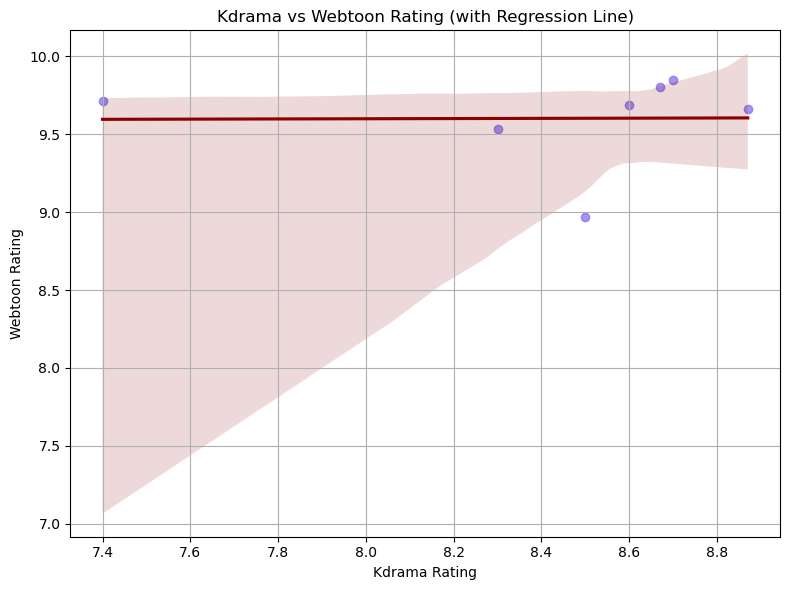

Pearson Correlation (r): 0.010
Very weak or no correlation
(p-value: 0.9827 — statistical significance less emphasized due to small sample size)


In [27]:
k_we_rating_df = df_adapt_combined.dropna(subset=['Kdrama Rating', 'WE Rating'])

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Kdrama Rating',
    y='WE Rating',
    data=k_we_rating_df,
    scatter_kws={'alpha': 0.7, 'color': 'mediumslateblue'},
    line_kws={'color': 'darkred'},
)
plt.title("Kdrama vs Webtoon Rating (with Regression Line)")
plt.xlabel("Kdrama Rating")
plt.ylabel("Webtoon Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(k_we_rating_df['Kdrama Rating'], k_we_rating_df['WE Rating'])

# Emphasize correlation strength
print(f"Pearson Correlation (r): {corr:.3f}")
if abs(corr) >= 0.7:
    print("Strong correlation")
elif abs(corr) >= 0.5:
    print("Moderate correlation")
elif abs(corr) >= 0.3:
    print("Weak to moderate correlation")
else:
    print("Very weak or no correlation")
print(f"(p-value: {p_value:.4f} — statistical significance less emphasized due to small sample size)")

* There is very weak or no correlation between Kdrama and webtoon ratings
* High webtoon rating does not necessarily guarantee high Kdrama rating (and vice versa)

## Top 10 Adaptations with Highest Average Watchers

In [17]:
df_ada_top_watched = df[['Title', 'Kdrama Watchers']].dropna()
top10_most_watched = df_ada_top_watched.dropna(subset=['Kdrama Watchers']).sort_values(
    by='Kdrama Watchers', ascending=False
).head(10)

top10_most_watched

,Title,Kdrama Watchers
211,What's Wrong with Secretary Kim,212766.0
159,True Beauty,162611.0
179,Itaewon Class,150987.0
308,Her Private Life,138021.0
185,Extraordinary You,136969.0
189,Love Alarm,123882.0
158,Sweet Home,119232.0
182,Start-Up,111863.0
312,The Uncanny Counter,107940.0
212,Cheese in the Trap,107382.0


## Kdrama Adaptation Views vs Webtoon Metrics
* Create a heatmap to identify which webtoon metric has the strongest correlation to average viewers (Kdrama Watchers):
    * Likes (popularity and engagement)
    * Views (exposure or reach)
    * Subscribers (long-term interest and retention)
    * Engagement (how actively engaged the audience is per view)

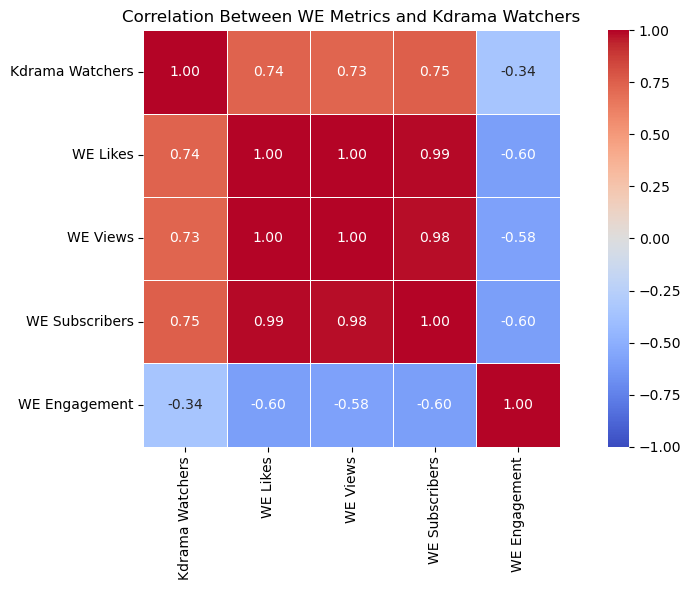

In [34]:
# Create heatmap
cols_to_compare = [
    'Kdrama Watchers',
    'WE Likes',
    'WE Views',
    'WE Subscribers',
    'WE Engagement'
]

df_corr = df[cols_to_compare].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(method='pearson')

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True,
)
plt.title("Correlation Between WE Metrics and Kdrama Watchers")
plt.tight_layout()
plt.show()

## Create a Composite Score of WE Likes, WE Views, and WE Subscribers
* Combine these three metrics to predict number of watchers of drama adaptations

In [42]:
# Normalize
scaler = StandardScaler()
df_scaled = scaler.fit_transform(
    df_adapt_combined[['WE Subscribers', 'WE Likes', 'WE Views']]
)

# Create composite score
df_adapt_combined['WE Composite Score'] = df_scaled.mean(axis=1)

df_clean = df_adapt_combined.dropna(subset=[
    'Kdrama Watchers', 'WE Subscribers', 'WE Likes', 'WE Views'
])

In [43]:
# Use regression to see if Subscribers vs Composite Score predict Kdrama Watchers

X_single = df_clean[['WE Subscribers']]
y = df_clean['Kdrama Watchers']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[['WE Subscribers', 'WE Likes', 'WE Views']])
df_clean['WE Composite Score'] = X_scaled.mean(axis=1)

X_composite = df_clean[['WE Composite Score']]

# Model A: Subscribers only
model_single = LinearRegression().fit(X_single, y)
y_pred_single = model_single.predict(X_single)
r2_single = r2_score(y, y_pred_single)

# Model B: Composite score
model_composite = LinearRegression().fit(X_composite, y)
y_pred_composite = model_composite.predict(X_composite)
r2_composite = r2_score(y, y_pred_composite)

print("R² Comparison:")
print(f"Model A - WE Subscribers only: R² = {r2_single:.3f}")
print(f"Model B - Composite (Subscribers + Likes + Views): R² = {r2_composite:.3f}")

if r2_composite > r2_single:
    print("Composite score performs better.")
else:
    print("Subscribers alone perform just as well or better.")


R² Comparison:
Model A - WE Subscribers only: R² = 0.568
Model B - Composite (Subscribers + Likes + Views): R² = 0.556
Subscribers alone perform just as well or better.


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/2736907000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['WE Composite Score'] = X_scaled.mean(axis=1)


## Most Popular Adaptation Genre
* Most popular genres from both Kdrama and webtoon

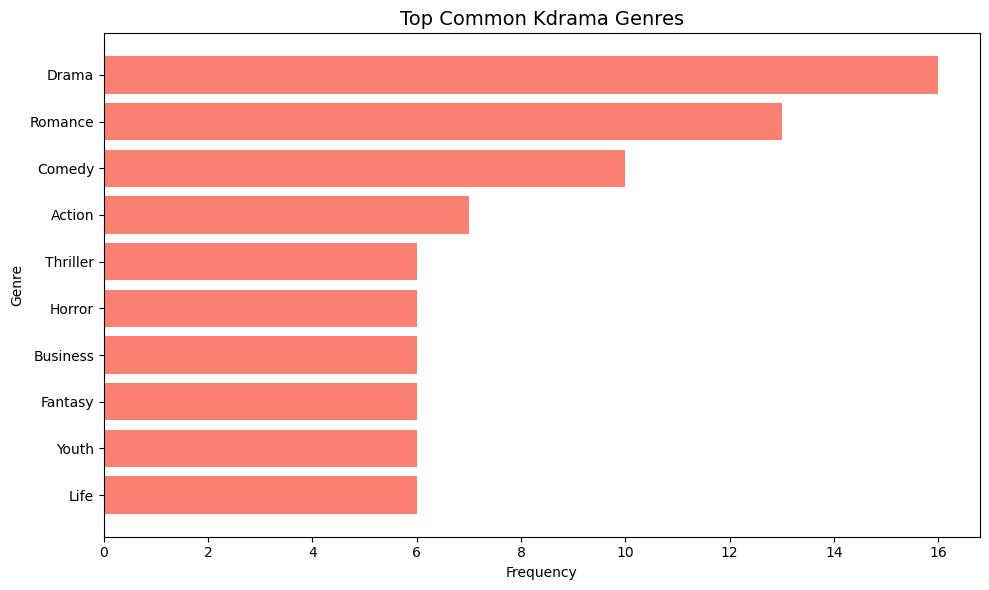

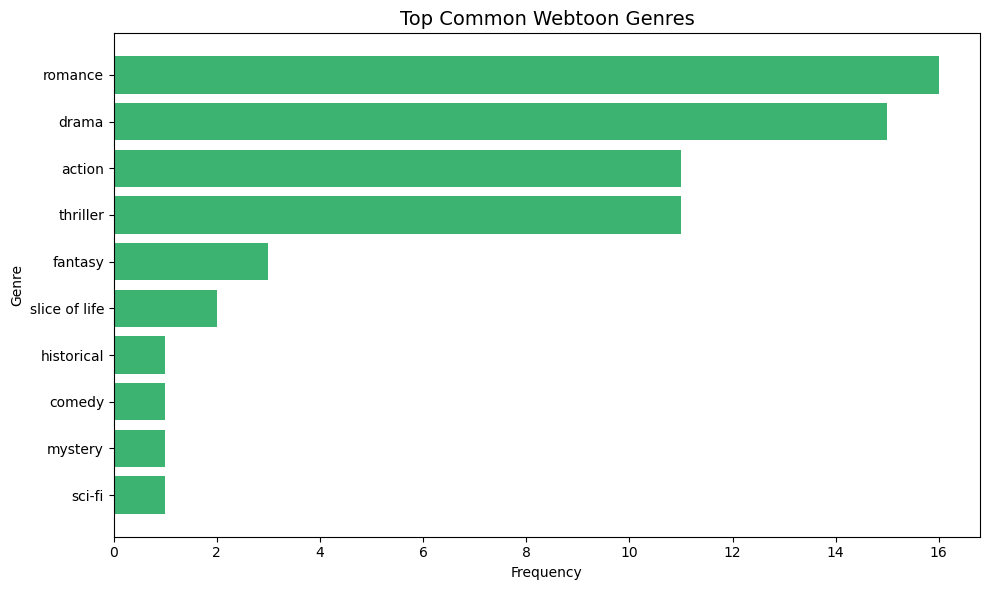

In [20]:
def genre_series_to_df(series):
    genre_counter = Counter()
    for entry in series.dropna():
        genres = [g.strip() for g in entry.split(',')]
        genre_counter.update(genres)

    genre_df = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Count'])
    genre_df = genre_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return genre_df

# Generate genre frequency DataFrames
kdrama_genre_df = genre_series_to_df(df_adapt_combined['Kdrama Genres'])
webtoon_genre_df = genre_series_to_df(df_adapt_combined['WE Genre'])

# Plotting function
def plot_genre_barplot(df, title, color='skyblue', top_n=10):
    plt.figure(figsize=(10, 6))
    top_df = df.head(top_n)
    plt.barh(top_df['Genre'][::-1], top_df['Count'][::-1], color=color)
    plt.title(title, fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

# Plot top genres
plot_genre_barplot(kdrama_genre_df, "Top Common Kdrama Genres", color='salmon')
plot_genre_barplot(webtoon_genre_df, "Top Common Webtoon Genres", color='mediumseagreen')

In [21]:
def get_all_genres(series_list):
    genres = set()
    for series in series_list:
        for entry in series.dropna():
            genres.update(g.strip() for g in entry.split(','))
    return sorted(genres)

all_genres = get_all_genres([df_adapt_combined['Kdrama Genres'], df_adapt_combined['WE Genre']])

def genre_presence_matrix(df, column, genre_list, prefix):
    matrix = pd.DataFrame(0, index=df.index, columns=genre_list)
    for i, entry in df[column].dropna().items():
        genres = [g.strip() for g in entry.split(',')]
        for genre in genres:
            if genre in matrix.columns:
                matrix.at[i, genre] = 1
    matrix.columns = [f"{prefix}_{col}" for col in matrix.columns]
    return matrix

kdrama_genres_bin = genre_presence_matrix(df_adapt_combined, 'Kdrama Genres', all_genres, 'K')
webtoon_genres_bin = genre_presence_matrix(df_adapt_combined, 'WE Genre', all_genres, 'W')
kdrama_counts = kdrama_genres_bin.sum().rename(lambda x: x[2:])  
webtoon_counts = webtoon_genres_bin.sum().rename(lambda x: x[2:])

contingency_df = pd.DataFrame([kdrama_counts, webtoon_counts], index=['Kdrama', 'Webtoon'])
chi2, p, dof, expected = chi2_contingency(contingency_df)
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)

# See which genres contribute most to chi-square
residuals = (contingency_df - expected) ** 2 / expected
top_contributors = residuals.sum().sort_values(ascending=False).head(10)
print("\nTop contributing genres to Chi-square:")
print(top_contributors)
if p < 0.05:
    print("Genre presence in Kdrama and webtoon is dependent")
else:
    print("Genre presence in Kdrama and webtoon is independent")

Chi-square statistic: 161.0
Degrees of freedom: 29
P-value: 3.037610945849242e-20

Top contributing genres to Chi-square:
romance     25.548387
drama       23.951613
thriller    17.564516
action      17.564516
Drama       10.020202
Romance      8.141414
Comedy       6.262626
fantasy      4.790323
Action       4.383838
Business     3.757576
dtype: float64
Genre presence in Kdrama and webtoon is dependent


## Kdrama vs Webtoon Popularity Correlation Test

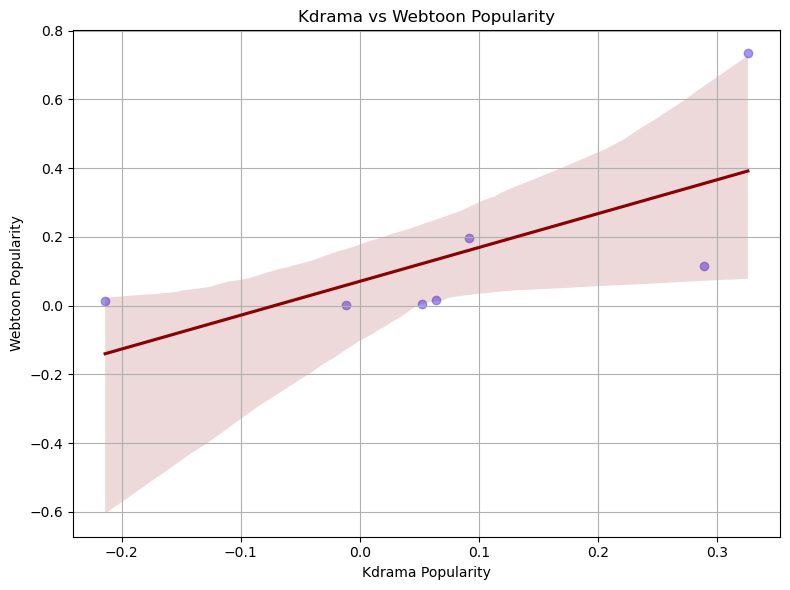

Pearson Correlation (r): 0.676
Moderate correlation
(p-value: 0.0951 — statistical significance less emphasized due to small sample size)


In [44]:
popularity_df = df_adapt_combined.dropna(subset=['Kdrama Popularity', 'WE Popularity'])

# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Kdrama Popularity',
    y='WE Popularity',
    data=popularity_df,
    scatter_kws={'alpha': 0.7, 'color': 'mediumslateblue'},
    line_kws={'color': 'darkred'},
)
plt.title("Kdrama vs Webtoon Popularity")
plt.xlabel("Kdrama Popularity")
plt.ylabel("Webtoon Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(popularity_df['Kdrama Popularity'], popularity_df['WE Popularity'])
print(f"Pearson Correlation (r): {corr:.3f}")
if abs(corr) >= 0.7:
    print("Strong correlation")
elif abs(corr) >= 0.5:
    print("Moderate correlation")
elif abs(corr) >= 0.3:
    print("Weak to moderate correlation")
else:
    print("Very weak or no correlation")
print(f"(p-value: {p_value:.4f} — statistical significance less emphasized due to small sample size)")

## Adaptation vs All Webtoon and Kdrama Data Comparison
* Adaptation WE Subscribers vs All Webtoon Subscribers
* Adaptation Kdrama Viewers vs All Kdrama Viewers
* Adaptation WE Rating vs All Webtoon Rating
* Adaptation Kdrama Rating vs All Kdrama Rating
* Adaptation WE Popularity vs All Webtoon Popularity
* Adaptation Kdrama Popularity vs All Kdrama Ppopularity

In [49]:
def compare_metric(df1, df2, col1, col2, label1='Adaptation', label2='General', title=None):
    data1 = df1[col1].dropna()
    data2 = df2[col2].dropna()

    # Determine if data is skewed (use non-parametric if needed)
    stat_test = mannwhitneyu if (abs(data1.skew()) > 1 or abs(data2.skew()) > 1) else ttest_ind
    test_name = "Mann-Whitney U" if stat_test == mannwhitneyu else "T-test"

    stat, p = stat_test(data1, data2)

    # Combine into one DataFrame for plotting
    combined_df = pd.DataFrame({
        'Value': np.concatenate([data1, data2]),
        'Group': [label1] * len(data1) + [label2] * len(data2)
    })

    # Plot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')
    plot_title = title if title else f'{col1} vs {col2} Comparison'
    plt.title(f'{plot_title}\n{test_name} p-value = {p:.4f}')
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\nComparison using {test_name}")
    print(f"Mean {label1} ({col1}): {data1.mean():,.2f}")
    print(f"Mean {label2} ({col2}): {data2.mean():,.2f}")
    print(f"p-value: {p:.4f} {'Significant' if p < 0.05 else 'Not significant'}")

df_adapted = pd.read_csv("data/combined/not-clean/adaptations_clean.csv")
df_kdramas = pd.read_csv('data/combined/not-clean/drama_combined.csv')
df_kdramas_pop = pd.read_csv("data/combined/clean/drama_combined_clean.csv")
df_webtoons = pd.read_csv("data/combined/not-clean/webtoon_combined.csv")
df_webtoons_pop = pd.read_csv("data/combined/clean/we_combined_clean.csv")

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


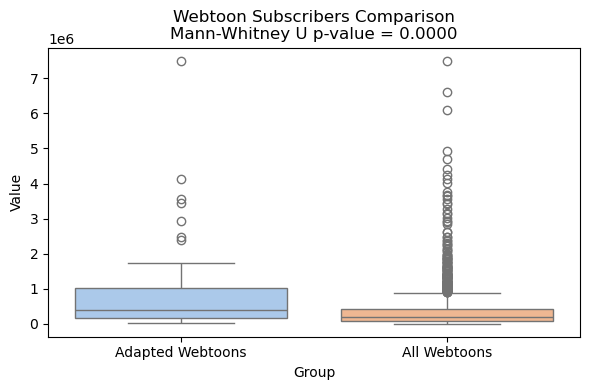


Comparison using Mann-Whitney U
Mean Adapted Webtoons (WE Subscribers): 867,443.84
Mean All Webtoons (Subscribers): 384,976.10
p-value: 0.0000 Significant


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


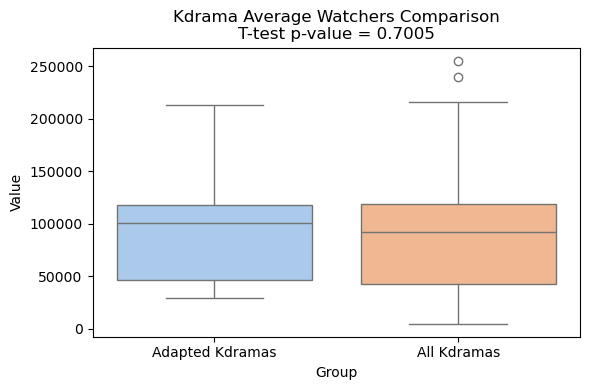

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')



Comparison using T-test
Mean Adapted Kdramas (Kdrama Watchers): 93,342.46
Mean All Kdramas (Watchers): 89,135.51
p-value: 0.7005 Not significant


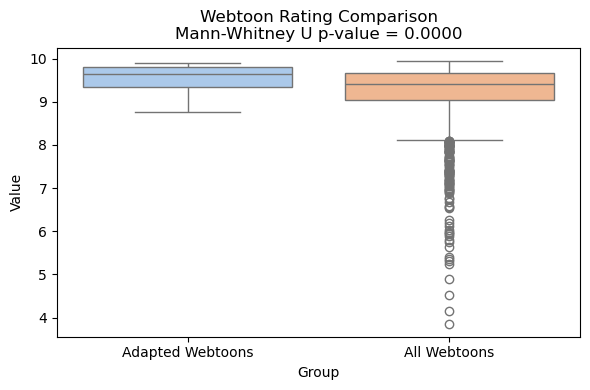


Comparison using Mann-Whitney U
Mean Adapted Webtoons (WE Rating): 9.55
Mean All Webtoons (Rating): 9.21
p-value: 0.0000 Significant


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


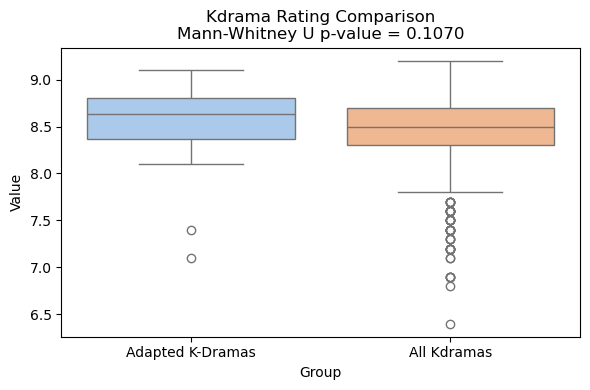


Comparison using Mann-Whitney U
Mean Adapted K-Dramas (Kdrama Rating): 8.52
Mean All Kdramas (Rating): 8.42
p-value: 0.1070 Not significant


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


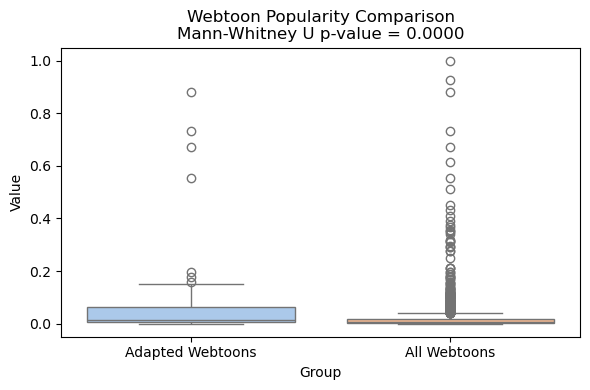


Comparison using Mann-Whitney U
Mean Adapted Webtoons (WE Popularity): 0.08
Mean All Webtoons (Popularity): 0.02
p-value: 0.0000 Significant


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


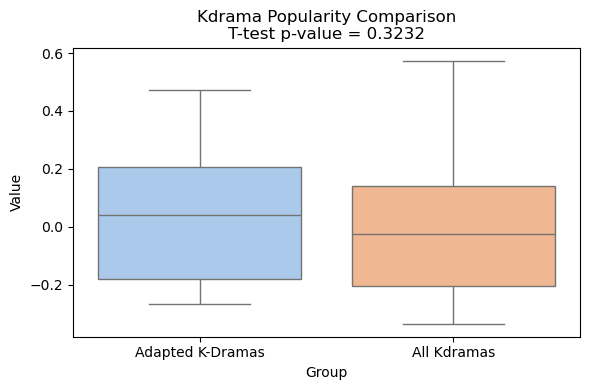


Comparison using T-test
Mean Adapted K-Dramas (Kdrama Popularity): 0.03
Mean All Kdramas (Popularity): -0.02
p-value: 0.3232 Not significant


In [50]:
# Adaptation WE Subscribers vs All Webtoon Subscribers
compare_metric(
    df_adapted, df_webtoons, 
    col1='WE Subscribers', col2='Subscribers', 
    label1='Adapted Webtoons', label2='All Webtoons',
    title='Webtoon Subscribers Comparison'
)

# Adaptation Kdrama Viewers vs All Kdrama Viewers
compare_metric(
    df_adapted, df_kdramas, 
    col1='Kdrama Watchers', col2='Watchers', 
    label1='Adapted Kdramas', label2='All Kdramas',
    title='Kdrama Average Watchers Comparison'
)

# Adaptation WE Rating vs All Webtoon Rating
compare_metric(
    df_adapted, df_webtoons, 
    col1='WE Rating', col2='Rating', 
    label1='Adapted Webtoons', label2='All Webtoons',
    title='Webtoon Rating Comparison'
)

# Adaptation Kdrama Rating vs All Kdrama Rating
compare_metric(
    df_adapted, df_kdramas,
    col1='Kdrama Rating', col2='Rating',
    label1='Adapted K-Dramas', label2='All Kdramas',
    title='Kdrama Rating Comparison'
)

# Adaptation WE Popularity vs All Webtoon Popularity
compare_metric(
    df_adapted, df_webtoons_pop, 
    col1='WE Popularity', col2='Popularity', 
    label1='Adapted Webtoons', label2='All Webtoons',
    title='Webtoon Popularity Comparison'
)

# Adaptation Kdrama Popularity vs All Kdrama Popularity
compare_metric(
    df_adapted, df_kdramas_pop,
    col1='Kdrama Popularity', col2='Popularity',
    label1='Adapted K-Dramas', label2='All Kdramas',
    title='Kdrama Popularity Comparison'
)

* Adaptation alone doesn't guarantee stronger popularity in drama form
* This could also be attributed to the small dataset size
* Test if successful adaptations (those in the top 25% webtoons by subscribers) truly outperform other kdramas 

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


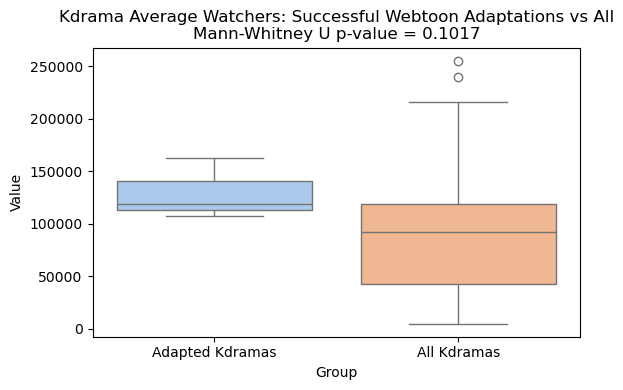


Comparison using Mann-Whitney U
Mean Adapted Kdramas (Kdrama Watchers): 129,741.67
Mean All Kdramas (Watchers): 89,135.51
p-value: 0.1017 Not significant


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')


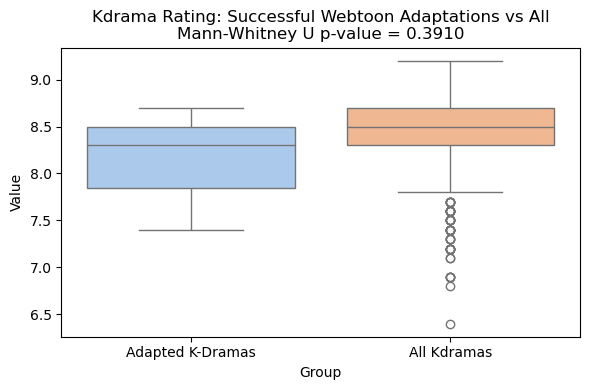

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/871182709.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_df, palette='pastel')



Comparison using Mann-Whitney U
Mean Adapted K-Dramas (Kdrama Rating): 8.13
Mean All Kdramas (Rating): 8.42
p-value: 0.3910 Not significant


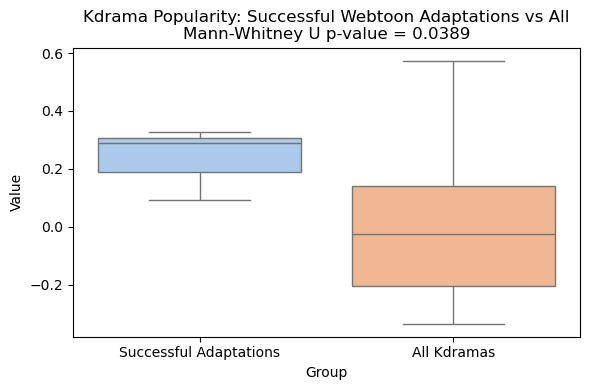


Comparison using Mann-Whitney U
Mean Successful Adaptations (Kdrama Popularity): 0.24
Mean All Kdramas (Popularity): -0.02
p-value: 0.0389 Significant


In [58]:
threshold = df_adapted['WE Subscribers'].quantile(0.75)
df_successful_adapted = df_adapted[df_adapted['WE Subscribers'] >= threshold]

# Top Webtoon Adaptations vs All Kdrama Watchers
compare_metric(
    df_successful_adapted, df_kdramas, 
    col1='Kdrama Watchers', col2='Watchers', 
    label1='Adapted Kdramas', label2='All Kdramas',
    title='Kdrama Average Watchers: Successful Webtoon Adaptations vs All'
)

# Top Webtoon Adaptations vs All Kdrama Rating
compare_metric(
    df_successful_adapted, df_kdramas,
    col1='Kdrama Rating', col2='Rating',
    label1='Adapted K-Dramas', label2='All Kdramas',
    title='Kdrama Rating: Successful Webtoon Adaptations vs All'
)

# Top Webtoon Adaptations vs Kdrama Popularity
compare_metric(
    df_successful_adapted, df_kdramas_pop,
    col1='Kdrama Popularity', col2='Popularity',
    label1='Successful Adaptations', label2='All Kdramas',
    title='Kdrama Popularity: Successful Webtoon Adaptations vs All'
)

* Kdramas adapted from successful webtoons have significantly higher popularity than general Kdramas, but when it comes to rating and viewers, there's not significance
* Even though adaptations overall may not show a big advantage, adapted dramas that come from high-performing webtoons tend to perform much better
* Identifying high-potential webtoons can likely predict high-potential drama adaptations

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/3350918467.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_compare, x='Group', y='Popularity', palette='pastel')


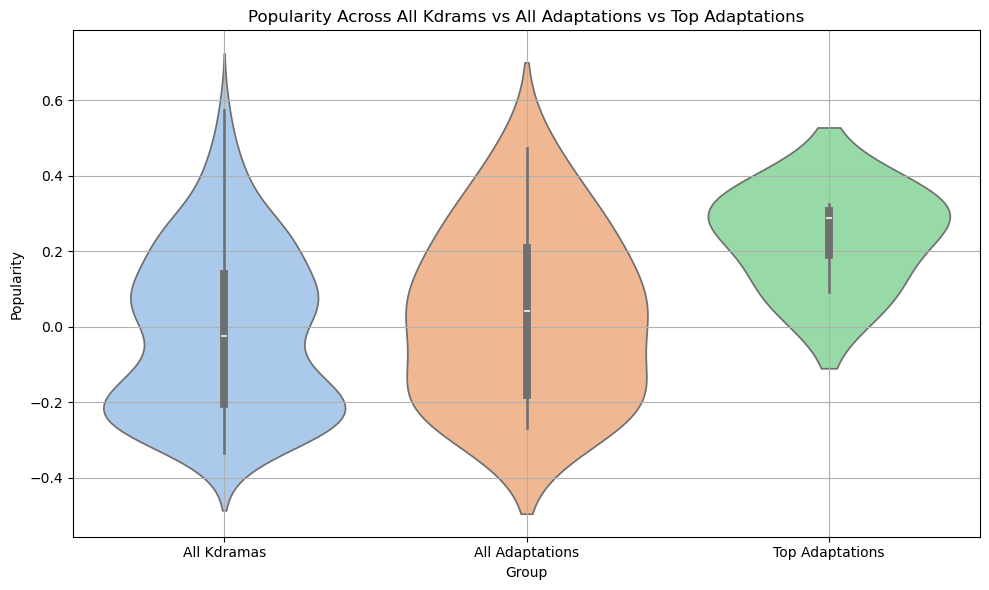

3-Way Kruskal-Wallis Test
Kruskal-Wallis H-statistic: 5.2048
p-value: 0.0741
No statistically significant difference detected.


In [67]:
# 3-Way Comparison (All Adaptations, Top Adaptations, Kdramas)

threshold = df_adapted['WE Subscribers'].quantile(0.75)
df_top_adapted = df_adapted[df_adapted['WE Subscribers'] >= threshold]
all_kdramas = df_kdrama['Popularity'].dropna()
adapted_kdramas = df_adapted['Kdrama Popularity'].dropna()
top_adapted_kdramas = df_top_adapted['Kdrama Popularity'].dropna()

df_compare = pd.DataFrame({
    'Popularity': pd.concat([all_kdramas, adapted_kdramas, top_adapted_kdramas], ignore_index=True),
    'Group': (
        ['All Kdramas'] * len(all_kdramas) +
        ['All Adaptations'] * len(adapted_kdramas) +
        ['Top Adaptations'] * len(top_adapted_kdramas)
    )
})

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_compare, x='Group', y='Popularity', palette='pastel')
plt.title("Popularity Across All Kdrams vs All Adaptations vs Top Adaptations")
plt.grid(True)
plt.tight_layout()
plt.show()

# Kruskal-Wallis Test (non-parametric 3-group test)
stat, p_value = kruskal(all_kdramas, adapted_kdramas, top_adapted_kdramas)

print("3-Way Kruskal-Wallis Test")
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("There is a statistically significant difference between at least one of the groups.")
else:
    print("No statistically significant difference detected.")


In [66]:
def run_mwu(group1, group2, label1, label2):
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"{label1} vs {label2}:")
    print(f"  U = {stat:.4f}, p = {p:.4f}")
    if p < 0.05:
        print("Significant\n")
    else:
        print("Not significant\n")

run_mwu(all_kdramas, adapted_kdramas, "All Kdramas", "All Adaptations")
run_mwu(adapted_kdramas, top_adapted_kdramas, "All Adaptations", "Top Adaptations")
run_mwu(all_kdramas, top_adapted_kdramas, "All Kdramas", "Top Adaptations")


All Kdramas vs All Adaptations:
  U = 2075.5000, p = 0.3124
Not significant

All Adaptations vs Top Adaptations:
  U = 14.5000, p = 0.0856
Not significant

All Kdramas vs Top Adaptations:
  U = 82.5000, p = 0.0389
Significant



* Compared to the average Kdrama, there is no evidence that webtoon adaptations as a whole perform differently
* There's a suggestive indication that top adaptations do better than average adaptations,  but this is not statistically conclusive. Could be attributed to the limited sample size
* Top adaptations have significantly higher Kdrama popularity than the average Kdrama

## Webtoon Creator Frequency Across Adaptations

In [89]:
creator_counts = df_adapted['WE Creators'].value_counts()
observed = creator_counts.values
expected = [observed.sum() / len(observed)] * len(observed)

# Chi-square test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant: Some creators are overrepresented.")
else:
    print("Not significant: Adaptations appear evenly distributed among creators.")

Chi-square statistic: 3.4839
p-value: 1.0000
Not significant: Adaptations appear evenly distributed among creators.


In [90]:
# Creator Frequency Among Top Popular Adaptations

popularity_threshold = df_adapted['Kdrama Popularity'].quantile(0.75)
top_adaptations_df = df_adapted[df_adapted['Kdrama Popularity'] >= popularity_threshold]
top_creator_counts = top_adaptations_df['WE Creators'].value_counts()
all_creator_counts = df_adapted['WE Creators'].value_counts()

common_creators = top_creator_counts.index.intersection(all_creator_counts.index)
observed = top_creator_counts.loc[common_creators].values
expected_raw = all_creator_counts.loc[common_creators].values
expected = expected_raw * (observed.sum() / expected_raw.sum())

# Chi-square test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant: Some creators are overrepresented among top Kdrama adaptations.")
else:
    print("Not significant: No strong overrepresentation detected.")

Chi-square statistic: 0.0000
p-value: 1.0000
Not significant: No strong overrepresentation detected.


* Creator frequency is not statistically significant across Kdrama adaptations
* It's important to consider that the adaptation dataset is limited

## Kdrama Cast Frequency Across Adaptations

In [88]:
cast_col = "Kdrama Cast"  
cast_lists = df_adapted[cast_col].dropna().apply(lambda x: [i.strip() for i in str(x).split(',')])
all_cast = [member for sublist in cast_lists for member in sublist]
cast_counts = pd.Series(Counter(all_cast)).sort_values(ascending=False)

# Show top 10 
print(cast_counts.head(10))
top_n = 10
top_cast = cast_counts.head(top_n)
observed = top_cast.values
expected = [observed.sum() / len(observed)] * len(observed)

# Run chi-square test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant: Some cast members are overrepresented in adaptations.")
else:
    print("Not significant: No cast member is strongly overrepresented.")

Song Kang          3
Ryu Seung Ryong    2
Ro Woon            2
Pyo Ye Jin         2
Lee Je Hoon        2
Nam Joo Hyuk       2
Kim Do Wan         2
Kang Han Na        2
Park Min Young     2
Park Jin Joo       2
dtype: int64
Chi-square statistic: 0.4286
p-value: 1.0000
Not significant: No cast member is strongly overrepresented.


In [91]:
# Cast Frequency Across Top Popular Adapatations 

popularity_col = "Kdrama Popularity"  
threshold = df_adapted[popularity_col].quantile(0.75)
top_adapt_df = df_adapted[df_adapted[popularity_col] >= threshold]
cast_col = "Kdrama Cast" 

top_cast_lists = top_adapt_df[cast_col].dropna().apply(lambda x: [i.strip() for i in str(x).split(',')])

top_cast_all = [member for sublist in top_cast_lists for member in sublist]
top_cast_counts = pd.Series(Counter(top_cast_all)).sort_values(ascending=False)

print(top_cast_counts.head(10))
all_cast_lists = df_adapted[cast_col].dropna().apply(lambda x: [i.strip() for i in str(x).split(',')])
all_cast_all = [member for sublist in all_cast_lists for member in sublist]
all_cast_counts = pd.Series(Counter(all_cast_all))


common_cast = top_cast_counts.index.intersection(all_cast_counts.index)
observed = top_cast_counts.loc[common_cast].values
expected_raw = all_cast_counts.loc[common_cast].values
expected = expected_raw * (observed.sum() / expected_raw.sum())

# Run chi-square test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant: Certain cast members are overrepresented in top adaptations.")
else:
    print("Not significant: No strong overrepresentation among top cast members.")

Park Seo Joon     2
Ahn Bo Hyun       2
Park Min Young    2
Cha Eun Woo       1
Kim Young Pil     1
Song Kang         1
Song Sun Mi       1
Kim Byung Ok      1
Kim Hye Ok        1
Lee Tae Hwan      1
dtype: int64
Chi-square statistic: 4.5978
p-value: 1.0000
Not significant: No strong overrepresentation among top cast members.


* While there is no strong overrepresentation of particular cast across adaptations, the top adaptations do have famous actors/actresses listed (Park Seo Joon, Ahn Bo Hyun, Park Min Young, Cha Eun Woo) 

## Webtoon Genre vs Adaptation Popularity

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_2176/1467558408.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


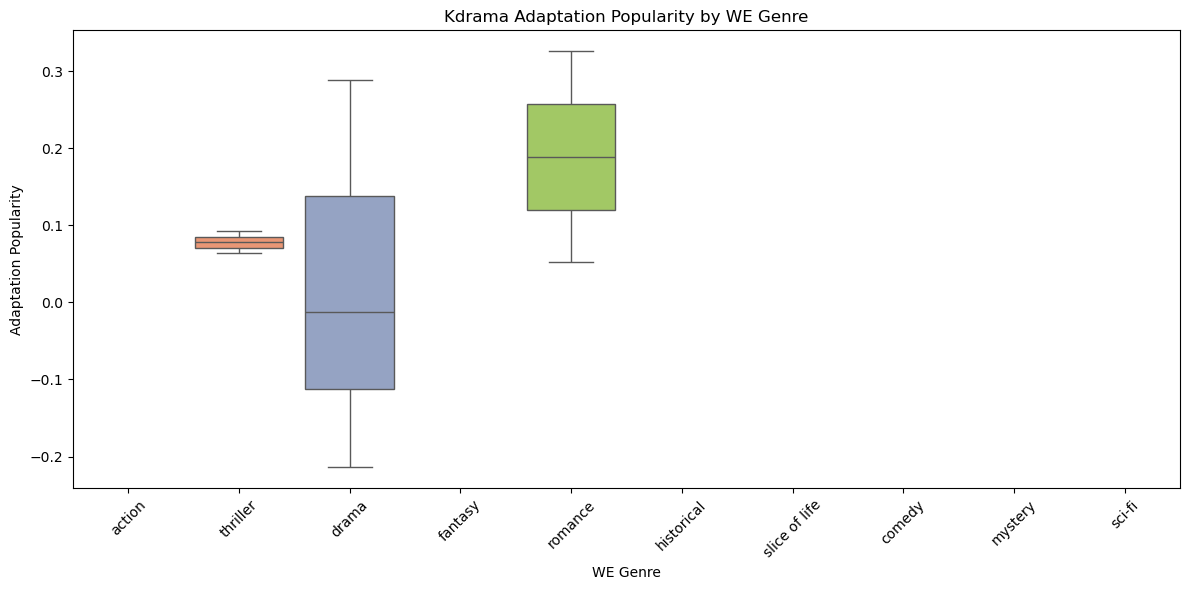

ANOVA F-statistic: 0.4097
p-value: 0.6889
Not significant: No clear genre effect on adaptation popularity.


In [95]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_adapted,
    x="WE Genre",          
    y="Kdrama Popularity",          
    palette="Set2"
)
plt.title("Kdrama Adaptation Popularity by WE Genre")
plt.xticks(rotation=45)
plt.ylabel("Adaptation Popularity")
plt.xlabel("WE Genre")
plt.tight_layout()
plt.show()

valid_genres = ["romance", "drama", "action", "thriller"]
filtered_df = df_adapted[df_adapted["WE Genre"].isin(valid_genres)].copy()

# Group the popularity values by genre
groups = [
    group["Kdrama Popularity"].dropna().values
    for name, group in df_adapted.groupby("WE Genre")  \
    if len(group["Kdrama Popularity"].dropna()) > 1 
]

# Run ANOVA
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant: Adaptation popularity differs by webtoon genre.")
else:
    print("Not significant: No clear genre effect on adaptation popularity.")

## Episodes vs Adaptation Popularity

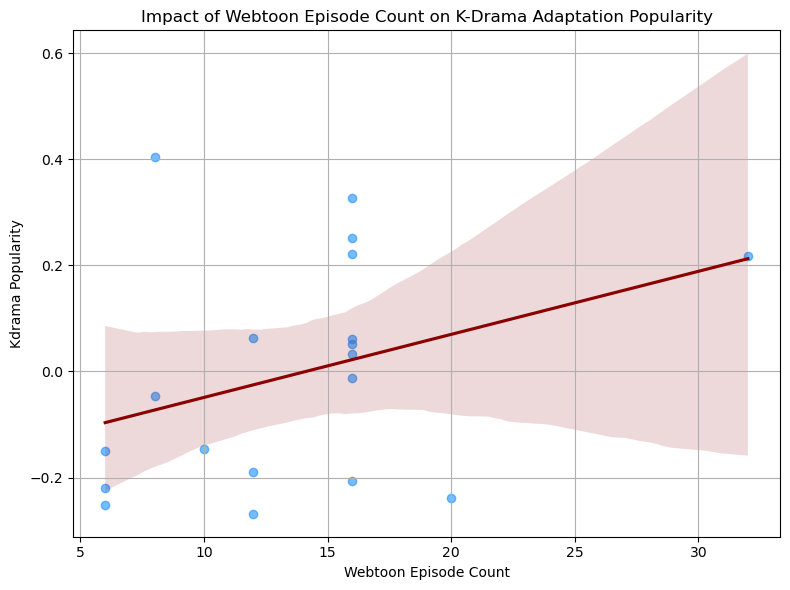

Pearson Correlation (r): 0.345
P-value: 0.1474
No significant correlation between episode count and popularity.


In [96]:
df_ep = df_adapted.dropna(subset=["Episodes", "Kdrama Popularity"])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_ep,
    x="Episodes",
    y="Kdrama Popularity",
    scatter_kws={"alpha": 0.6, "color": "dodgerblue"},
    line_kws={"color": "darkred"}
)
plt.title("Impact of Webtoon Episode Count on K-Drama Adaptation Popularity")
plt.xlabel("Webtoon Episode Count")
plt.ylabel("Kdrama Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
r, p = pearsonr(df_ep["Episodes"], df_ep["Kdrama Popularity"])
print(f"Pearson Correlation (r): {r:.3f}")
print(f"P-value: {p:.4f}")
if p < 0.05:
    print("Significant correlation between episode count and popularity.")
else:
    print("No significant correlation between episode count and popularity.")